# Creating a dataset

In [10]:
import os
import pickle
import random
import mediapipe as mp
import cv2
import numpy as np

try:
    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles

    hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

    DATA_DIR = 'C:\\Users\\Dell\\Desktop\\archivenew\\Indian'
    NUM_IMAGES_PER_CLASS = 1000
    MIN_SAMPLES_PER_CLASS = 300

    data = []
    labels = []

    for dir_ in os.listdir(DATA_DIR):
        dir_path = os.path.join(DATA_DIR, dir_)
        image_paths = os.listdir(dir_path)
        random.shuffle(image_paths)
        selected_images = image_paths[:NUM_IMAGES_PER_CLASS]
        temp_data = []
        
        for img_path in selected_images:
            data_aux = []
            img = cv2.imread(os.path.join(dir_path, img_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = hands.process(img_rgb)
            
            if results.multi_hand_landmarks:
                hand_count = len(results.multi_hand_landmarks)
                for hand_landmarks in results.multi_hand_landmarks:
                    x_ = []
                    y_ = []
                    
                    for i in range(len(hand_landmarks.landmark)):
                        x = hand_landmarks.landmark[i].x
                        y = hand_landmarks.landmark[i].y
                        x_.append(x)
                        y_.append(y)

                    for i in range(len(hand_landmarks.landmark)):
                        x = hand_landmarks.landmark[i].x
                        y = hand_landmarks.landmark[i].y
                        data_aux.append(x - min(x_))
                        data_aux.append(y - min(y_))
                
                if len(data_aux) == 42:
                    data_aux.extend([0.0] * 42)
                    temp_data.append(data_aux)
                elif len(data_aux) == 84:
                    temp_data.append(data_aux)
        
        if len(temp_data) >= MIN_SAMPLES_PER_CLASS:
            data.extend(temp_data)
            labels.extend([dir_] * len(temp_data))

    data = np.asarray(data, dtype=np.float32)
    labels = np.asarray(labels)
except:
    with open('asl.pickle', 'wb') as f:
        pickle.dump({'data': data, 'labels': labels}, f)

with open('asl.pickle', 'wb') as f:
    pickle.dump({'data': data, 'labels': labels}, f)


In [6]:
import os
import pickle
import random
import mediapipe as mp
import cv2
import numpy as np

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.4)

DATA_DIR = 'C:\\Users\\Dell\\Desktop\\archivenew\\Indian'
NUM_IMAGES_PER_CLASS = 10
MIN_SAMPLES_PER_CLASS = 5

data = []
labels = []

total_images_processed = 0
total_images_added = 0

for dir_ in os.listdir(DATA_DIR):
    dir_path = os.path.join(DATA_DIR, dir_)
    image_paths = os.listdir(dir_path)
    random.shuffle(image_paths)
    selected_images = image_paths[:NUM_IMAGES_PER_CLASS]
    temp_data = []
    
    for img_path in selected_images:
        img = cv2.imread(os.path.join(dir_path, img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = hands.process(img_rgb)
        
        total_images_processed += 1
        
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                x_ = []
                y_ = []
                
                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y
                    x_.append(x)
                    y_.append(y)

                data_aux = []
                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y
                    data_aux.append(x - min(x_))
                    data_aux.append(y - min(y_))

                if len(data_aux) == 42:
                    data_aux.extend([0.0] * 42)
                    temp_data.append(data_aux)
                elif len(data_aux) == 84:
                    temp_data.append(data_aux)

    if len(temp_data) >= MIN_SAMPLES_PER_CLASS:
        data.extend(temp_data)
        labels.extend([dir_] * len(temp_data))
        total_images_added += len(temp_data)

data = np.asarray(data, dtype=np.float32)
labels = np.asarray(labels)

with open('asl.pickle', 'wb') as f:
    pickle.dump({'data': data, 'labels': labels}, f)


Initializing Mediapipe Hands and Drawing modules...
Mediapipe Hands initialized with static_image_mode=True and min_detection_confidence=0.4
Data directory: C:\Users\Dell\Desktop\archivenew\Indian
Number of images per class: 10
Minimum samples per class: 5
Starting to process directories...
Saving processed data and labels into 'asl.pickle'...t.Indian\Z


# Defining and training the model

In [7]:
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np


data_dict = pickle.load(open('./asl.pickle', 'rb'))

data = np.asarray(data_dict['data'])
labels = np.asarray(data_dict['labels'])

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels)

model = RandomForestClassifier()

model.fit(x_train, y_train)

y_predict = model.predict(x_test)

score = accuracy_score(y_predict, y_test)

print('{}% of samples were classified correctly !'.format(score * 100))

f = open('model.p', 'wb')
pickle.dump({'model': model}, f)
f.close()

98.96907216494846% of samples were classified correctly !


# Predicting

In [8]:
#Final Model Test

import warnings

import pickle
import cv2
import mediapipe as mp
import numpy as np
import time

import pyttsx3

warnings.filterwarnings("ignore")
engine = pyttsx3.init()


model_dict = pickle.load(open('./model.p', 'rb'))
model = model_dict['model']


cap = cv2.VideoCapture(0)

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.3)

output = ""
timer_started = False
timer_duration = 3
current_timer = timer_duration
current_character = ""
box_color = (0, 0, 255)  


drawing_spec = mp_drawing.DrawingSpec(thickness=2, circle_radius=2, color=(0, 0, 255))

while True:
    data_aux = []
    x_ = []
    y_ = []

    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)

    H, W, _ = frame.shape

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results = hands.process(frame_rgb)

    if results.multi_hand_landmarks:
        if not timer_started:
            timer_started = True
            start_time = time.time()

        for hand_landmarks in results.multi_hand_landmarks:
           
            mp_drawing.draw_landmarks(
                frame,  
                hand_landmarks, 
                mp_hands.HAND_CONNECTIONS, 
                drawing_spec,  
                drawing_spec  
            )

            for i in range(len(hand_landmarks.landmark)):
                x = hand_landmarks.landmark[i].x
                y = hand_landmarks.landmark[i].y

                x_.append(x)
                y_.append(y)

            
            for i in range(len(hand_landmarks.landmark)):
                x = hand_landmarks.landmark[i].x
                y = hand_landmarks.landmark[i].y
                data_aux.append(x - min(x_))  
                data_aux.append(y - min(y_))  

       
        if len(data_aux) == 42:
            data_aux.extend([0.0] * 42) 

       
        if len(data_aux) == 84:
           
            prediction = model.predict([np.asarray(data_aux)])
            current_character = prediction[0]

            
            elapsed_time = time.time() - start_time
            current_timer = timer_duration - elapsed_time

           
            cv2.putText(frame, f"Timer: {int(current_timer)}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

            
            box_color = (0, 0, 255) 

           
            x1 = int(min(x_) * W) - 10
            y1 = int(min(y_) * H) - 10
            x2 = int(max(x_) * W) - 10
            y2 = int(max(y_) * H) - 10
            cv2.rectangle(frame, (x1, y1), (x2, y2), box_color, 4)

           
            cv2.putText(frame, current_character, (x1, y1 - 20), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 0, 0), 3, cv2.LINE_AA)

            
            if current_timer <= 0:
                
                box_color = (0, 255, 0) 

               
                cv2.rectangle(frame, (x1, y1), (x2, y2), box_color, 4)

                if current_character == 'space': 
                    output += ' ' 
                else:
                    output += current_character

                
                timer_started = False  
                current_timer = timer_duration  
                current_character = "" 

    else:

        timer_started = False
        current_timer = timer_duration 
        box_color = (0, 0, 255) 

   
    cv2.imshow('frame', frame)
    cv2.waitKey(1)

    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


print("Final Sentence:", output)


cap.release()
cv2.destroyAllWindows()

say = input("Do you want to speak")

if say.lower() == 'yes':
    engine.say(output)
    engine.runAndWait()


Final Sentence: SYDBB


DATA VISUALISATION

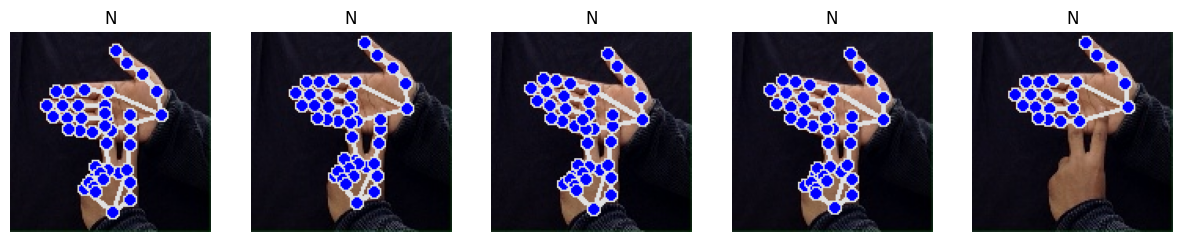

In [25]:
import cv2
import mediapipe as mp
import random
import os
import matplotlib.pyplot as plt  
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

DATA_DIR = 'D:\\data\\Indian'
sample_class = random.choice(os.listdir(DATA_DIR))
sample_images = random.sample(os.listdir(os.path.join(DATA_DIR, sample_class)), 5)

hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.5)

plt.figure(figsize=(15, 5))

for i, img_path in enumerate(sample_images):
    img = cv2.imread(os.path.join(DATA_DIR, sample_class, img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)
    
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(img_rgb, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    
    plt.subplot(1, len(sample_images), i + 1)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(sample_class)

plt.show()
